In [8]:
import pyrootutils

root = pyrootutils.setup_root(
    search_from="/Users/max/Desktop/Masterthesis/code/focus_model/notebooks/test.ipynb",
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

import torch 
import glob
from torchvision.transforms import transforms
import skimage
from skimage import io
import os
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Callback, LightningDataModule, LightningModule, Trainer
from tqdm import tqdm
import cv2

from src.utils.color_filter import ColorFilter
from src.datamodules.focus_datamodule_jiang import FocusDataModuleJiang
from src.datamodules.components.jiang_dataset import JiangDataset
from src.models.components.ynet_spectral import YNet_spectral
from src.models.components.ynet_mixed import YNet_mixed
from src.models.focus_module_jiang import FocusModuleJiang
from src.models.components.mobile_net_v3 import MobileNetV3


In [2]:
train_dataset_dir = "/home/maf4031/focus_model/data/jiang_datasets/dataset_patch_train.pt"
test_dataset_dir = "/home/maf4031/focus_model/data/jiang_datasets/dataset_patch_test_same.pt"
ckpt_path = "/home/maf4031/focus_model/logs/experiment/runs/2023-03-27_12-28-45/checkpoints/epoch_020.ckpt"

In [3]:
#model = YNet_mixed()
model = MobileNetV3()

device = torch.device("cuda")
state_dict = torch.load(ckpt_path, map_location=device)['state_dict']
state_dict = {k.replace("net.", ""): v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model = model.to(device)
_ = model.eval()

In [4]:
datamodule = FocusDataModulePatch(
    train_dataset_dir=train_dataset_dir,
    test_dataset_dir=test_dataset_dir,
    batch_size=1,
    transformations=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0), (1))])
    )
datamodule.setup()
val_loader = datamodule.val_dataloader()
train_loader = datamodule.train_dataloader()
test_loader = datamodule.test_dataloader()
print(len(train_loader), len(val_loader), len(test_loader))

102959 25740 13940


In [7]:
errors = []
device = torch.device("cuda")
model = model.to(device)
for batch in tqdm(iter(test_loader)):
    x, y, _ = batch
    x = x.to(device)
    with torch.no_grad():
        y_hat = model(x)
    y_hat = y_hat.detach().cpu().numpy()
    errors.append(np.abs(y_hat - y.numpy()))
print(np.mean(errors))

 63%|██████▎   | 8809/13940 [27:11<16:00,  5.34it/s]

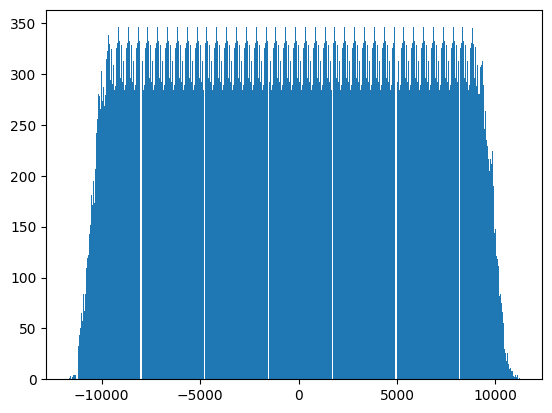

In [43]:
labels, labels_count = np.unique(train_loader.dataset.dataset.array_labels, return_counts=True)
plt.bar(labels, labels_count, width=49)
plt.show()

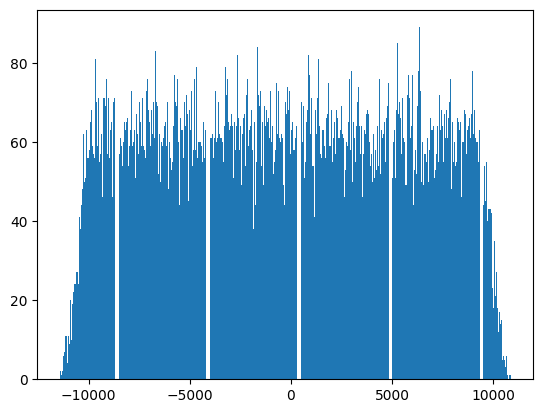

In [38]:
val_indices = val_loader.dataset.indices
all_labels = train_loader.dataset.dataset.array_labels
val_labels = [all_labels[i] for i in val_indices]
val_labels, val_labels_count = np.unique(val_labels, return_counts=True)
plt.bar(val_labels, val_labels_count, width=48)
plt.show()

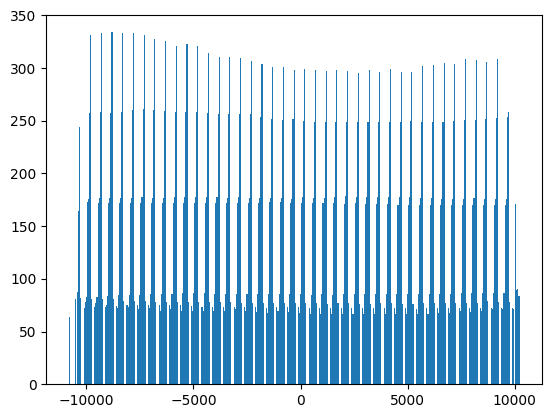

In [44]:
labels, labels_count = np.unique(test_loader.dataset.array_labels, return_counts=True)
plt.bar(labels, labels_count, width=50)
plt.show()

In [10]:
model = YNet_mixed()

device = torch.device("cuda")
state_dict = torch.load(ckpt_path, map_location=device)['state_dict']
state_dict = {k.replace("net.", ""): v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model = model.to(device)
_ = model.eval()

val_loader = datamodule.val_dataloader()

In [12]:
errors = []
for batch in tqdm(iter(val_loader)):
    x, y, _ = batch
    with torch.no_grad():
        x = x.to(device)
        y_hat = model(x)
    y_hat = y_hat.detach().cpu().numpy()
    y = y.detach().numpy()
    errors.append(np.abs(y_hat - y))
print(np.mean(errors))

100%|██████████| 25740/25740 [14:46<00:00, 29.04it/s]

43.910645


In [12]:
print(np.mean(errors))

6265.8633


In [11]:
errors = []
device = torch.device("cuda")
model = model.to(device)
for batch in tqdm(iter(test_loader)):
    x, y, _ = batch
    x = x.to(device)
    with torch.no_grad():
        y_hat = model(x)
    y_hat = y_hat.detach().cpu().numpy()
    errors.append(np.abs(y_hat - y.numpy()))
print(np.mean(errors))

 22%|██▏       | 10814/49960 [42:46<2:34:51,  4.21it/s]


KeyboardInterrupt: 

In [21]:
from typing import Any, Tuple, List
import cv2
import numpy as np


# upper and lower purple ranges in HSV color space
LOWER_HSV_RANGE = np.array([130,20,20])
UPPER_HSV_RANGE = np.array([180,255,255])


class ColorFilter:
    def __init__(
                self, 
                ) -> None:
        """Color filter to exclude images containing no or not enough tissue

        Parameters
        ----------
        threshold: float
            Ratio of pixels that correspond to tissue in image
        data_out_type: ImageFormats
            Enum defining final data type of filtered images for storage
        """
        self.counter_img_keep = 0
        self.counter_img_disregard = 0
    
    def _read_img(self, dir: str) -> np.array:
        return cv2.imread(dir)

    def _convert_BGR_to_HSV(self, img: np.array) -> np.array:
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    def _convert_RGB_to_HSV(self, img: np.array) -> np.array:
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    def _get_mask(self, img_hsv: np.array) -> np.array:
        return cv2.inRange(img_hsv, LOWER_HSV_RANGE, UPPER_HSV_RANGE)

    def _get_filtered_img(self, img: np.array, mask: np.array) -> np.array:
        return cv2.bitwise_and(img, img, mask=mask)
    
    def _filter(self, img: np.array) -> np.array:
        """Filter pipeline:
        1. Convert to HSV space
        2. Retrieve image mask
        3. Retrieve filtered image
        
        Parameters
        ----------
        img: np.array
            Input image
        
        Returns
        -------
        np.array
            Filtered image
        """
        hsv_img = self._convert_BGR_to_HSV(img)
        mask = self._get_mask(hsv_img)
        return self._get_filtered_img(img, mask)
    
    def _get_sample_ratio(self, img_arr: np.array) -> float:
        """Retrieves the ratio of the image containing sample
        
        Parameters
        ----------
        img_arr: np.array
            Input image
        
        Returns
        -------
        float
            Ratio of the image containing sample
        """
        hsv_img = self._convert_RGB_to_HSV(img_arr)
        mask = self._get_mask(hsv_img)
        sample_pixel_count = (mask/255).astype(int).sum()
        return (sample_pixel_count/mask.size)*100

color_filter = ColorFilter()

In [24]:
d = test_loader.dataset
i = color_filter._convert_RGB_to_HSV(d[0][0].squeeze().permute(1,2,0).numpy())
color_filter._get_mask()


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
color_filter = ColorFilter()
d = test_loader.dataset
ratio = []
c = 0
for batch in tqdm(d):
    if c%100 == 0:
        x, y, _ = batch
        ratio.append(color_filter._get_sample_ratio(x.squeeze().permute(1,2,0).numpy()))
    c += 1

In [25]:
protocol = "same" # "diff"
data_path = f"/n/data2/hms/dbmi/kyu/lab/maf4031/incoherent_RGBchannels/testRawData_incoherent_{protocol}Protocol"  
dataset = torch.load(f"/home/maf4031/focus_model/data/test/{protocol}_test_dataset.pt")

In [28]:
imgs_path = glob.glob(os.path.join(data_path,'*/*.jpg'))

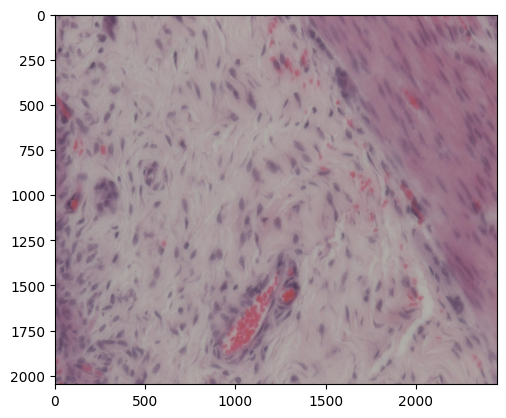

In [33]:
img = np.array(io.imread(imgs_path[0]))
plt.imshow(img)
plt.show()

In [35]:
image_size = (2048, 2448)
patch_size = (224, 224)

h, w = image_size
x_steps = int(h / patch_size[0])
y_steps = int(w / patch_size[1])
x_coord = np.linspace(int(patch_size[0]/2), h - int(patch_size[0]/2), x_steps)
y_coord = np.linspace(int(patch_size[1]/2), w - int(patch_size[1]/2), y_steps)
patch_coords = [(x, y) for x in x_coord for y in y_coord]

1936.0 2336.0


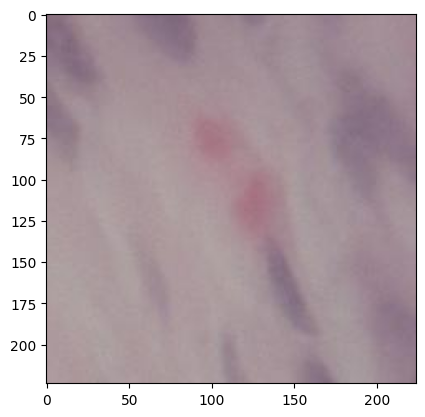

In [43]:
x, y = patch_coords[-1]
print(x,y)
patch = img[int(x-int(patch_size[0]/2)):int(x+int(patch_size[0]/2)), int(y-int(patch_size[1]/2)):int(y+int(patch_size[1]/2))]
plt.imshow(patch)
plt.show()

In [44]:
train_imgs_path = "/n/data2/hms/dbmi/kyu/lab/maf4031/incoherent_RGBchannels/train_incoherent_RGBChannels/s100_l1"
train_imgs_path = glob.glob(os.path.join(train_imgs_path,'*.jpg'))

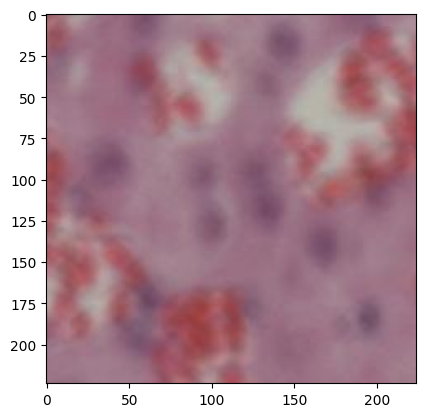

In [48]:
img = np.array(io.imread(train_imgs_path[-10]))
plt.imshow(img)
plt.show()

In [2]:
import pickle

In [3]:
path = "/home/maf4031/focus_model/output/test_prediction.pkl"
with open(path, "rb") as f:
    test_prediction = pickle.load(f)

# Test inference on single patches

In [1]:
ckpt_path = "/Users/max/Desktop/epoch_041.ckpt"

In [5]:
model = YNet_mixed()

device = torch.device("cpu")
state_dict = torch.load(ckpt_path, map_location=device)['state_dict']
state_dict = {k.replace("net.", ""): v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
_ = model.eval()

In [25]:
img_path = "/Users/max/Desktop/incoherent_RGBchannels/testRawData_incoherent_sameProtocol/s16_l1/defocus-350.jpg"
image_size = (2048, 2448)
patch_size = (224, 224)
array_images, array_labels = [], []

h, w = image_size
x_steps = int(h / patch_size[0])
y_steps = int(w / patch_size[1])
x_coord = np.linspace(int(patch_size[0]/2), h - int(patch_size[0]/2), x_steps)
y_coord = np.linspace(int(patch_size[1]/2), w - int(patch_size[1]/2), y_steps)
patch_coords = [(x, y) for x in x_coord for y in y_coord]

In [26]:
img = cv2.imread(img_path) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_resize = cv2.resize(img, (224, 224))

In [40]:
t = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0,1)])
preds = []
with torch.no_grad():
    for x, y in patch_coords:
        patch = img[int(x-int(patch_size[0]/2)):int(x+int(patch_size[0]/2)), int(y-int(patch_size[1]/2)):int(y+int(patch_size[1]/2))]
        img_tensor = t(patch)
        img_tensor = img_tensor.unsqueeze(0)    
        preds.append(model(img_tensor).numpy())
np.mean(preds)

-1169.5977

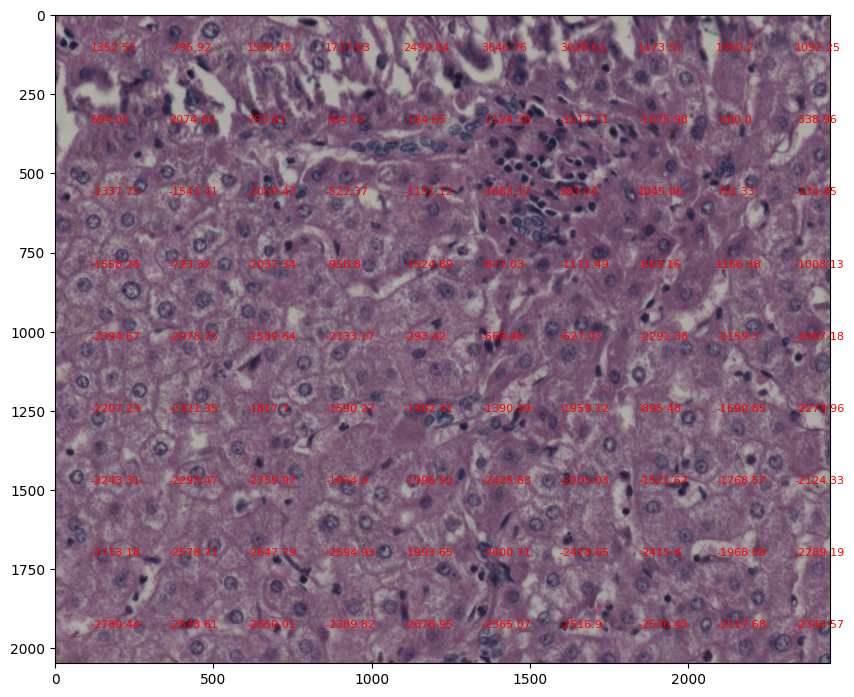

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(img)
# show predictions for each patch
for idx, (x, y) in enumerate(patch_coords):
    plt.text(y, x, str(round(preds[idx][0][0], 2)), color='red', fontsize=8)
plt.show()

In [44]:
len([pred for pred in preds if pred < 0])/len(preds)

0.8111111111111111

128699